In [1]:
import numpy as np
import networkx as nx
import pandas as pd

from scipy import stats

import causalpy as cp

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

import torch
import pytorch_lightning as pl

from catenets.models.torch import TARNet, SNet, FlexTENet
from models.causal_bert_pytorch.CausalBert import CausalBertWrapper

from econml.metalearners import SLearner, XLearner
from econml.dml import CausalForestDML
from econml.dr import LinearDRLearner
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning) 

/home/lars/temp/causal_inference/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

device

'cuda'

In [3]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

In [4]:
def plot_effect(effect_true, effect_pred, figsize=(10, 7), ylim=(5000, 22000)):
    plt.figure(figsize=figsize)
    plt.scatter(effect_true, effect_pred, color=COLORS[0])
    plt.plot(np.sort(effect_true), np.sort(effect_true), color=COLORS[1], alpha=.7, label='Perfect model')
    plt.xlabel('$True \\; \text{ß} \\; effect$', fontsize=14, alpha=.5)
    plt.ylabel(r'$Predicted \; \text{ß} \; effect$', fontsize=14, alpha=.5)
    plt.ylim(ylim[0], ylim[1])
    plt.legend()
    plt.show()

# Chapter 11.1

In [5]:
# Set random seed
SEED = 18
np.random.seed(SEED)
pl.seed_everything(SEED)  

Seed set to 18


## Going Deeper: Deep Learning for Heterogenous Treatment Effects

### Data

In [6]:
SAMPLE_SIZE = 5000
TRAIN_SIZE = 4500
N_FEATURES = 20

X = np.random.normal(0, 1, (SAMPLE_SIZE, N_FEATURES))
T = np.random.binomial(1, 0.5, SAMPLE_SIZE)

weights = np.random.gumbel(5, 10, (SAMPLE_SIZE, N_FEATURES - 1))

y = (50 * T * np.abs(X[:, 0])**1.2) + (weights * X[:, 1:]).sum(axis=1)

y0 = (50 * 0 * np.abs(X[:, 0])**1.2) + (weights * X[:, 1:]).sum(axis=1)
y1 = (50 * 1 * np.abs(X[:, 0])**1.2) + (weights * X[:, 1:]).sum(axis=1)


In [7]:
effect_true = y1[TRAIN_SIZE:] - y0[TRAIN_SIZE:] 

### S-Learner, X-Learner, DR-Learner & Causal Forest (Benchmark)

In [8]:
benchmark_models = {
    'SLearner': SLearner(overall_model=LGBMRegressor()),
    'XLearner': XLearner(models=LGBMRegressor()),
    'DRLearner': LinearDRLearner(),
    'CausalForest': CausalForestDML()
}

benchmark_results = {}


for model_name, model in benchmark_models.items():
    model.fit(
        X=X[:TRAIN_SIZE, :],
        T=T[:TRAIN_SIZE],
        Y=y[:TRAIN_SIZE]
    )

    effect_pred = model.effect(
        X[TRAIN_SIZE:]
    )
    
    benchmark_results[model_name] = effect_pred

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5104
[LightGBM] [Info] Number of data points in the train set: 4500, number of used features: 22
[LightGBM] [Info] Start training from score 20.369942
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 2278, number of used features: 20
[LightGBM] [Info] Start training from score 0.420480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 2222, number of used features: 20
[LightGBM] [Info] Start train

SLearner MAPE = 3.339113509099748


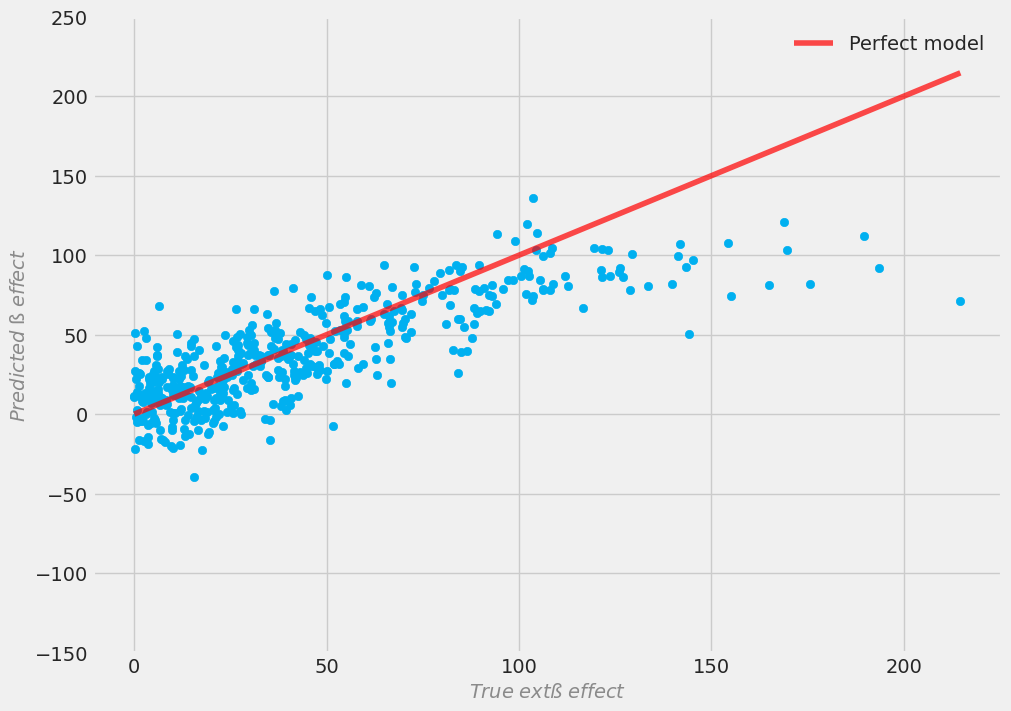

XLearner MAPE = 4.256833487010385


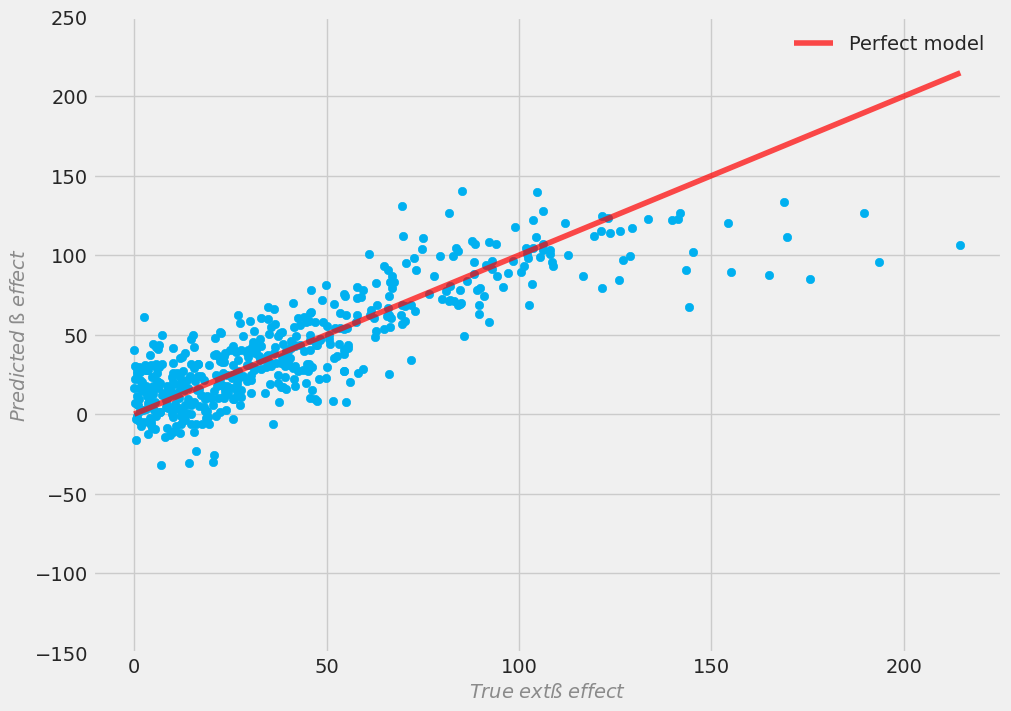

DRLearner MAPE = 8.70910258926995


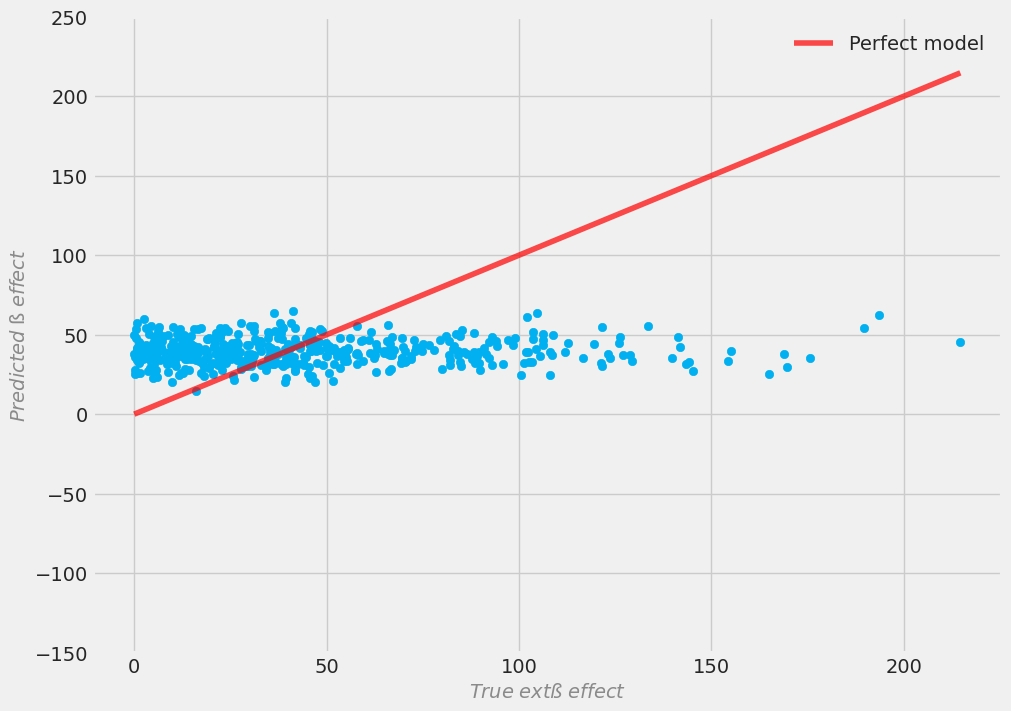

CausalForest MAPE = 3.6116188793757367


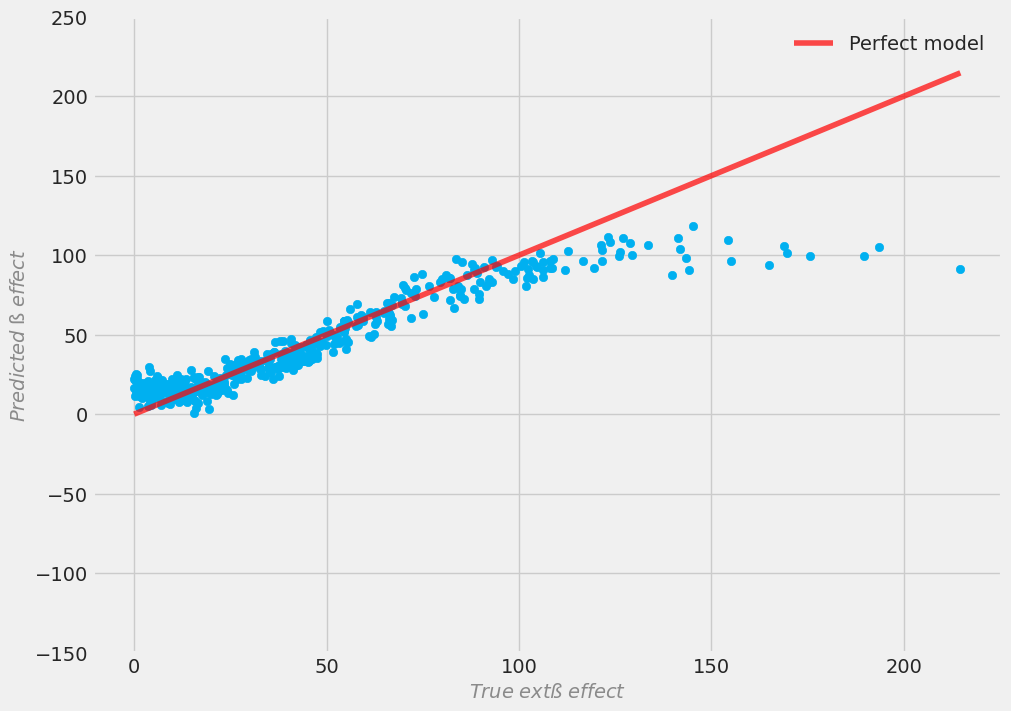

In [9]:
for model_name in benchmark_results.keys():
    effect_pred = benchmark_results[model_name]
    print(f'{model_name} MAPE = {mean_absolute_percentage_error(effect_true, effect_pred)}')
    
    plot_effect(
        effect_true=effect_true,
        effect_pred=effect_pred,
        ylim=(-150, 250)
    )

### TARNet

In [10]:
tarnet = TARNet(
    n_unit_in=X.shape[1],
    binary_y=False,
    n_units_out_prop=32,
    n_units_r=8,
    nonlin='selu',
)

tarnet.fit(
    X=X[:TRAIN_SIZE, :],
    y=y[:TRAIN_SIZE],
    w=T[:TRAIN_SIZE]
);


In [11]:
# Get predictions
effect_pred_tarnet = tarnet.predict(
    X=X[TRAIN_SIZE:, :]
).cpu().detach().numpy()

In [12]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred_tarnet)

In [13]:
?mean_absolute_percentage_error

Signature:
mean_absolute_percentage_error(
    y_true,
    y_pred,
    *,
    sample_weight=None,
    multioutput='uniform_average',
)
Docstring:
Mean absolute percentage error (MAPE) regression loss.

Note here that the output is not a percentage in the range [0, 100]
and a value of 100 does not mean 100% but 1e2. Furthermore, the output
can be arbitrarily high when `y_true` is small (which is specific to the
metric) or when `abs(y_true - y_pred)` is large (which is common for most
regression metrics). Read more in the
:ref:`User Guide <mean_absolute_percentage_error>`.

.. versionadded:: 0.24

Parameters
----------
y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
    Ground truth (correct) target values.

y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
    Estimated target values.

sample_weight : array-like of shape (n_samples,), default=None
    Sample weights.

multioutput : {'raw_values', 'uniform_average'} or array-like
    Defines aggregat

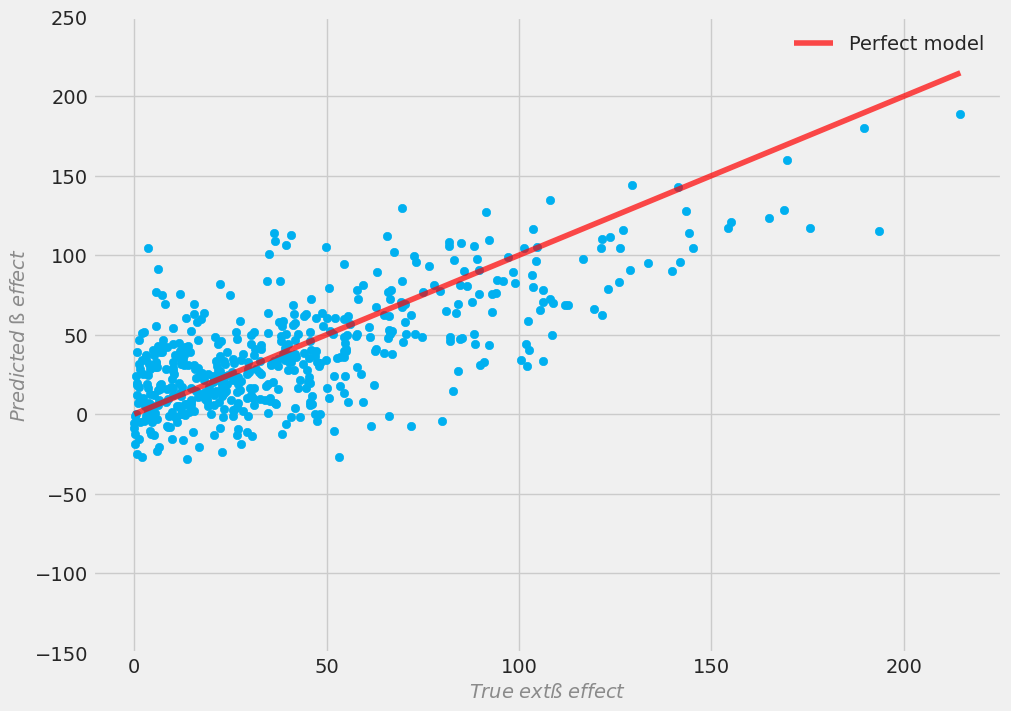

In [14]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred_tarnet,
    ylim=(-150, 250)
)

### SNet

In [15]:
snet = SNet(
    n_unit_in=X.shape[1],
    binary_y=False,
    n_units_out_prop=32,
    n_units_r=8,
    nonlin='selu',
)

snet.fit(
    X=X[:TRAIN_SIZE, :],
    y=y[:TRAIN_SIZE],
    w=T[:TRAIN_SIZE]
);

In [16]:
effect_pred_snet = snet.predict(
    X=X[TRAIN_SIZE:, :]
).cpu().detach().numpy()

In [17]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred_snet)

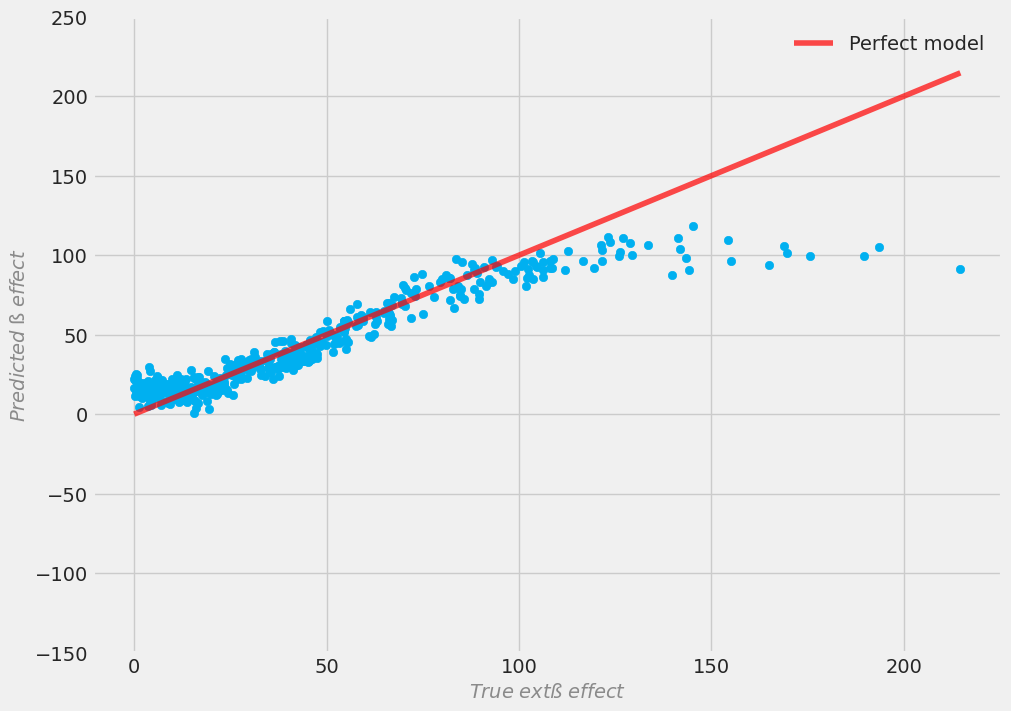

In [18]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
    ylim=(-150, 250)
)

## Transformers and Causal Inference

### Data

In [19]:
# Read-in
df = pd.read_csv('data/manga_processed.csv')          

In [20]:
# Shuffle observations
df = df.sample(frac=1)

In [21]:
df.head()

,text,subreddit,female_avatar,has_photo,upvote
106,I'm hooked on 'Hunter x Hunter' and its intric...,manga,0,0,0
165,I'm addicted to 'Black Clover' and its fast-pa...,manga,0,1,1
109,I'm blown away by 'One Piece' and its vast and...,manga,0,0,1
59,Just discovered 'Fruits Basket' and I'm in lov...,manga,1,0,0
168,I am obsessed with 'Naruto' and its emotional ...,manga,0,0,0


In [22]:
df.shape

### Modeling

In [23]:
# Re-running the model training? Un-comment the lines below and collect garbarge to free the GPU memory
# import gc
# del causal_bert
# gc.collect()
# torch.cuda.empty_cache()

# torch.cuda.is_available()

In [24]:
# Instantiate the model
causal_bert = CausalBertWrapper(
    batch_size=8,                      
    g_weight=0.05, 
    Q_weight=1., 
    mlm_weight=0.05
)

Some weights of CausalBert were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_cls.bias', 'g_cls.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# Train
causal_bert.train(
    texts=df['text'], 
    confounds=df['has_photo'], 
    treatments=df['female_avatar'], 
    outcomes=df['upvote'], 
    epochs=6
);

100%|███████████████████████████████████████████| 28/28 [00:03<00:00,  8.99it/s]


In [26]:
# Predict
preds = causal_bert.inference(
    texts=df['text'],
    confounds=df['has_photo'], 
)[0]

100%|███████████████████████████████████████████| 28/28 [00:00<00:00, 47.72it/s]


In [27]:
# Compute ATE
np.mean(preds[:, 1] - preds[:, 0])